In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from tqdm import tqdm

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

#### Load problem specific starter code

In [2]:
cd 'cs228/pa3'

/Users/lmcintosh/code/ipython-notebooks/classes/cs228/pa3


In [3]:
ls

cluster_graph.py   cluster_graph.pyc  do_pa3.py          do_pa3.pyc         factors.py         factors.pyc        images.mat         ldpc36-128.mat     ldpc36-1600.mat


In [4]:
import do_pa3

Doing part (a): Should see 0.0, 0.0, >0.0
(0.0, 0.0, 0.77378093749999988)
Doing part (c)


In [5]:
def test_channel_noise():
    p_test = [0.01, 0.05, 0.1, 0.5, 1.0]
    y = np.round(np.random.rand(100,20)).astype('int')
    fraction_flipped = []
    for p in p_test:
        yhat = do_pa3.applyChannelNoise(y, p)
        fraction_flipped.append(np.sum(abs(yhat - y))/(1.0*np.prod(y.shape)))
    for idp, p in enumerate(p_test):
        print('Actual p = %0.2f, empirical p = %0.2f' %(p, fraction_flipped[idp]))
#     print(fraction_flipped)
#     print(p_test)
#     return np.mean(np.array(p_test) - np.array(fraction_flipped))

In [6]:
test_channel_noise()

Actual p = 0.01, empirical p = 0.01
Actual p = 0.05, empirical p = 0.05
Actual p = 0.10, empirical p = 0.09
Actual p = 0.50, empirical p = 0.49
Actual p = 1.00, empirical p = 1.00


# Part (a)

In [7]:
do_pa3.do_part_a()

(0.0, 0.0, 0.77378093749999988)


# Part (b)

Implemented loopy BP

# Part (c)

In [8]:
from do_pa3 import *
from factors import *
from cluster_graph import *

ValueError: could not broadcast input array from shape (2,2,2,2,2,2,2,2,2,2,2,2,2,2,2) into shape (2,2,2,2,2,2,2,2,2,2)

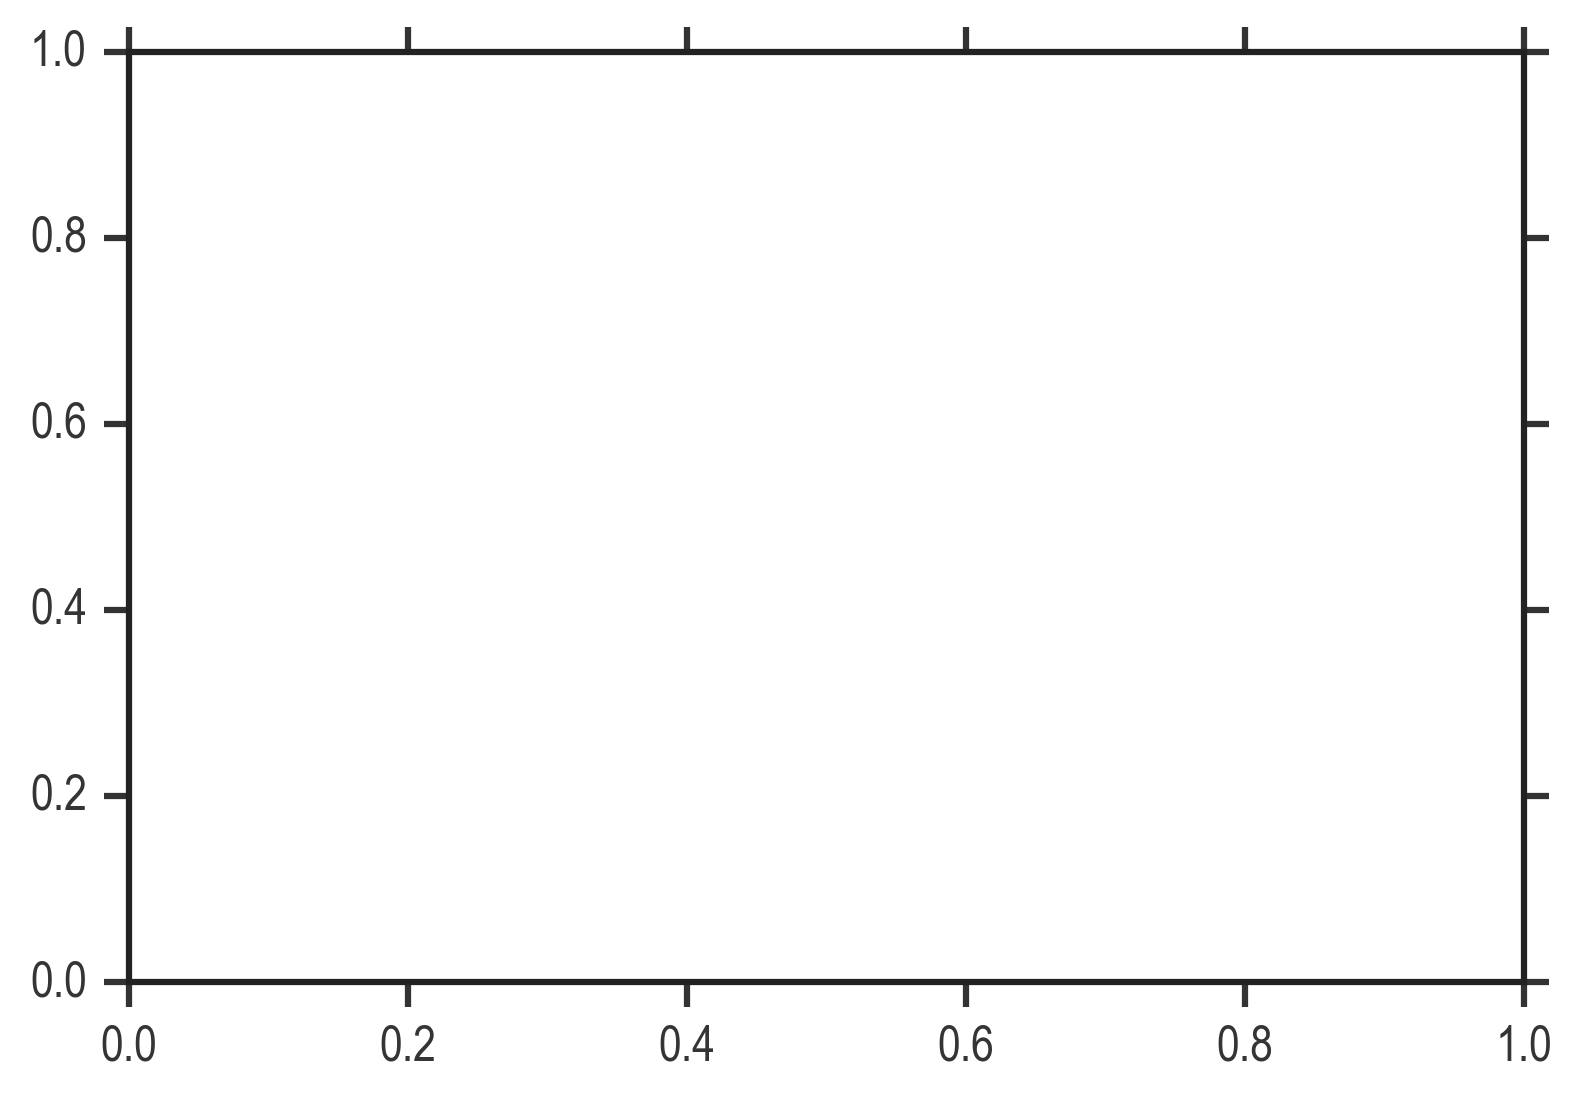

In [14]:
G, H = loadLDPC('ldpc36-128.mat')
p = 0.2
N = G.shape[1]
x = np.zeros((N, 1), dtype='int32')
y = encodeMessage(x, G)
##############################################################
# To do: your code starts here

# apply noise on y
yhat = applyChannelNoise(y, p)

# initialize graph
Graph = constructClusterGraph(yhat, H, p)

# initialize neighbors and messages
for i,f in enumerate(Graph.factor):
    Graph.nbr[i] = f.scope

    #for v in Graph.nbr[i]:
    for v in Graph.nbr[i]:
        to_var = Factor(scope=[v], card=[2], val=np.array([0.5, 0.5]))
        to_fac = Factor(scope=[v], card=[2], val=np.array([0.5, 0.5]))
        Graph.messages['var %d, fac %d' %(v,i)] = to_fac
        Graph.messages['fac %d, var %d' %(i,v)] = to_var

# initialize varToCliques
for var_i in range(len(Graph.varToCliques)):
    for fac_j,neighbors in enumerate(Graph.nbr):
        if var_i in neighbors:
            Graph.varToCliques[var_i].append(fac_j)

Graph.sepset = [[[] for j in xrange(len(Graph.factor))]
                    for i in xrange(len(Graph.factor))]
            
for i in range(H.shape[0]):
    for j in range(H.shape[1]):
        if H[i][j]:
            Graph.sepset[i][H.shape[0] + j].append(j)
            Graph.sepset[H.shape[0] + j][i].append(j)
            
            
iterations = 50
Graph.runParallelLoopyBP(iterations)

# collect probabilities that bits = 1
marginals = [Graph.estimateMarginalProbability(i)[1] for i in range(len(yhat))]

#     import pdb
#     pdb.set_trace()

# plot it
plt.scatter(range(len(yhat)), marginals, s=10, color='k')

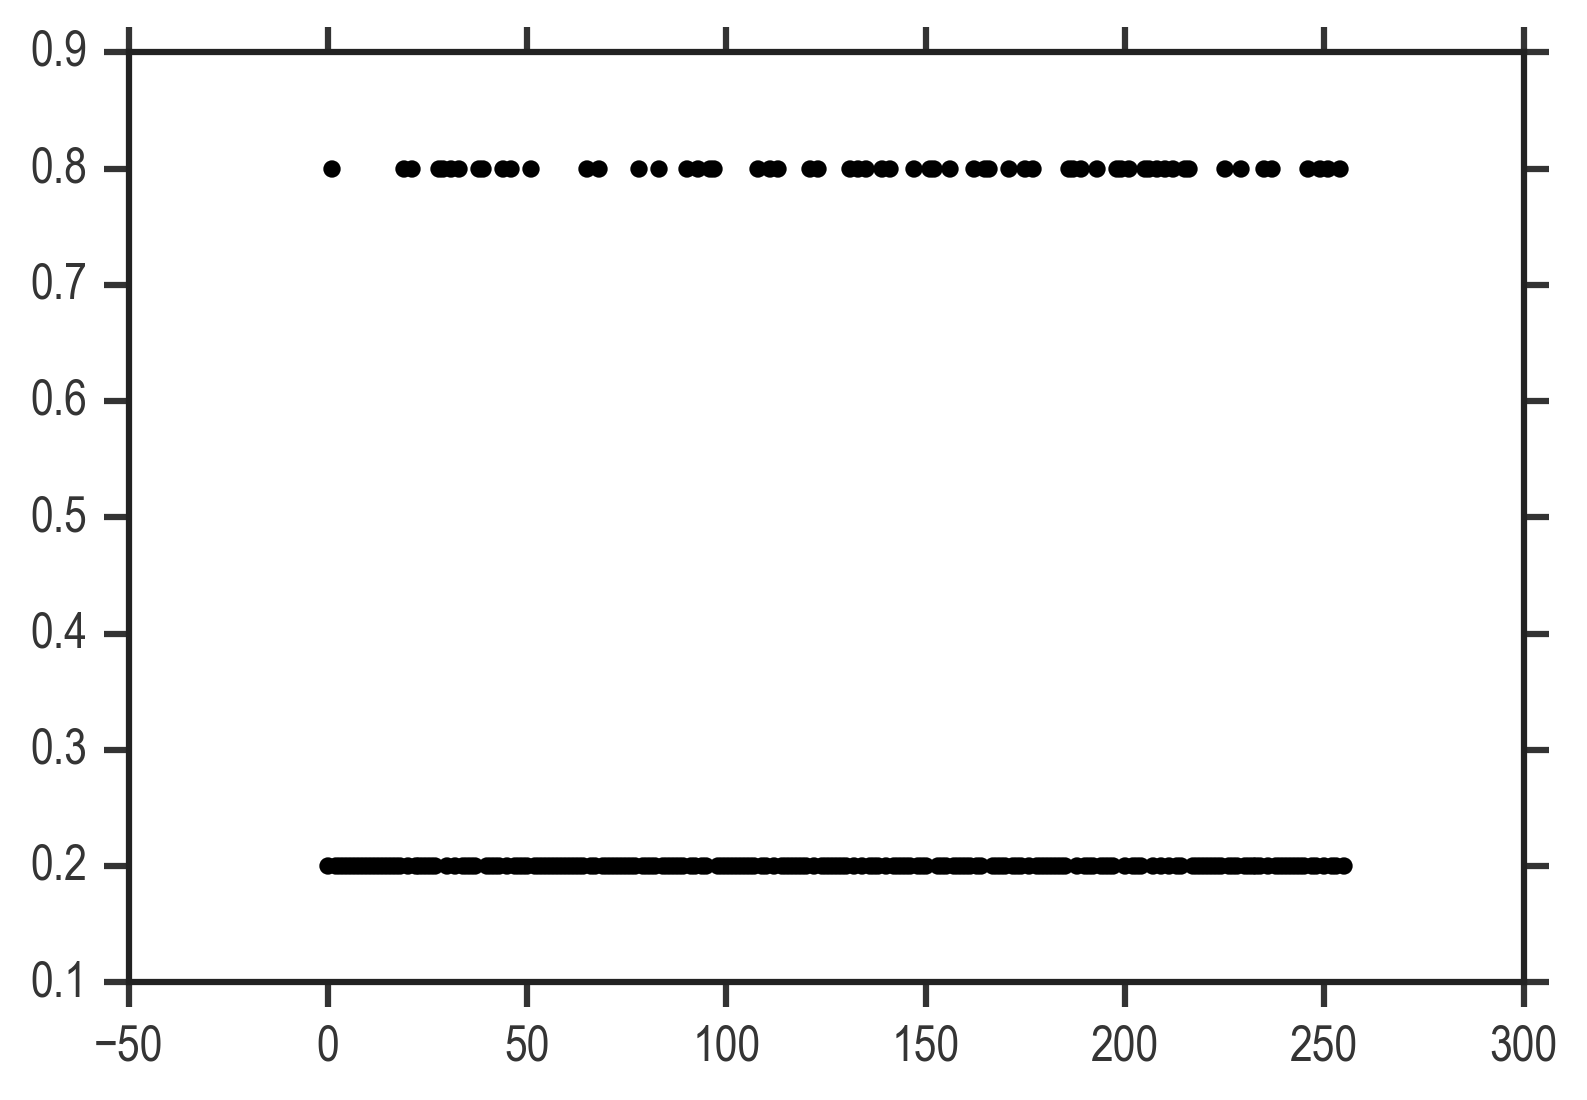

In [19]:
# collect probabilities that bits = 1
marginals = [Graph.estimateMarginalProbability(i)[1] for i in range(len(yhat))]

#     import pdb
#     pdb.set_trace()

# plot it
plt.scatter(range(len(yhat)), marginals, s=10, color='k')